In [54]:
%matplotlib inline
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as mplt
import re
import os

def ab_stats(balancer, file):
    # files = ['ab_100_10.txt', 'ab_1000_100.txt', 'ab_10000_1000.txt']
    folders = [
        'roundrobin-1', 'roundrobin-2', 'roundrobin-3', 
        'leastconn-1', 'leastconn-2', 'leastconn-3',
    ]
    tests = pd.DataFrame(
        columns=[
            'duration', 'complete_requests', 'req_per_sec', 'transfer_rate', 
            'connection_mean', 'connection_sd'
        ]
    )

    for folder in folders:
        measurement = {}
        with open(os.path.join(os.path.join(balancer, folder), file), 'r') as ab:
            for line in ab:
                if (m := re.search(r'Time taken for tests:\s+(\d*\.?\d*)', line)):
                    measurement['duration'] = m.group(1)
                elif (m := re.search('Complete requests:\s+(\d+)', line)):
                    measurement['complete_requests'] = m.group(1)
                elif (m := re.search('Requests per second:\s+(\d*\.?\d*)', line)):
                    measurement['req_per_sec'] = m.group(1)
                elif (m := re.search('Transfer rate:\s+(\d*\.?\d*)', line)):
                    measurement['transfer_rate'] = m.group(1)
                elif (m := re.search('Total:\s+\d+\s*(\d+)\s+(\d*\.?\d*)', line)):
                    measurement['connection_mean'] = m.group(1)
                    measurement['connection_sd'] = m.group(2)
        tests = tests.append(pd.Series(measurement, name=folder))

    tests['req_per_sec'] = tests['req_per_sec'].apply(pd.to_numeric)
    tests['connection_mean'] = tests['connection_mean'].apply(pd.to_numeric)
    tests['connection_sd'] = tests['connection_sd'].apply(pd.to_numeric)

    return tests  

def ab_plot(b, fieldname):
    algo = pd.DataFrame(columns=['nodes', 'roundrobin', 'leastconn'])
    for n in range(1, 4):
        stats = pd.Series({
            'nodes': n,
            'roundrobin': b.at[f'roundrobin-{n}', fieldname], 
            'leastconn': b.at[f'leastconn-{n}', fieldname]
        })
        algo = algo.append(stats, ignore_index=True)
        
    return algo
    
def ab_request_frequency_plot(benchmark, name):
    algo = ab_plot(benchmark, 'req_per_sec')
    plt = algo.plot.bar(x='nodes', y=['roundrobin', 'leastconn'],
                    title=name,  grid=True)
    plt.set_xlabel('Počet uzlov')
    plt.set_ylabel('Počet požiadaviek za sekundu')
    
def ab_connection_mean(benchmark, name):
    algo = ab_plot(benchmark, 'connection_mean')
    std = ab_plot(benchmark, 'connection_sd')
    
    plt = algo.plot.bar(x='nodes', y=['roundrobin', 'leastconn'],
                    title=name,  grid=True, 
                    yerr=std[['roundrobin', 'leastconn']].T.values)
    plt.set_xlabel('Počet uzlov')
    plt.set_ylabel('Priemerné trvanie požiadavky [ms]')


In [55]:
a = ab_stats('haproxy_ab', 'ab_1000_100.txt')
a

,duration,complete_requests,req_per_sec,transfer_rate,connection_mean,connection_sd
roundrobin-1,2.507,1000,398.81,1121.89,238,30.1
roundrobin-2,2.131,1000,469.23,1320.37,193,164.5
roundrobin-3,1.508,1000,663.33,1864.52,144,58.2
leastconn-1,2.504,1000,399.43,1123.43,238,31.0
leastconn-2,1.660,1000,602.39,1694.57,155,101.5
leastconn-3,1.342,1000,745.14,2094.88,124,88.5


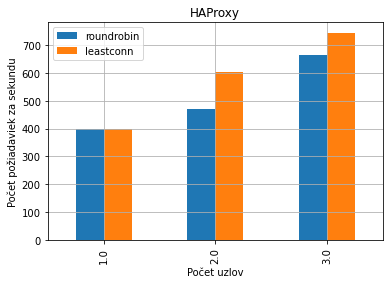

In [56]:
ab_request_frequency_plot(a, 'HAProxy')

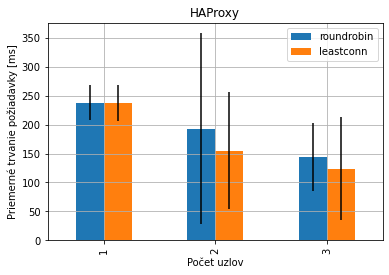

In [57]:
ab_connection_mean(a, 'HAProxy')

In [58]:
a = ab_stats('nginx_ab', 'ab_1000_100.txt')
a

,duration,complete_requests,req_per_sec,transfer_rate,connection_mean,connection_sd
roundrobin-1,2.476,1000,403.92,1134.90,236,144.2
roundrobin-2,2.093,1000,477.83,1342.58,188,162.0
roundrobin-3,1.484,1000,673.97,1893.05,139,109.6
leastconn-1,2.426,1000,412.18,1158.32,230,29.4
leastconn-2,1.647,1000,607.22,1707.44,151,67.2
leastconn-3,1.303,1000,767.63,2158.03,121,93.3


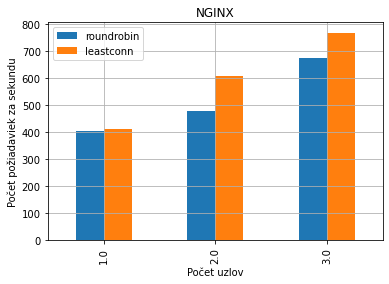

In [59]:
ab_request_frequency_plot(a, 'NGINX')

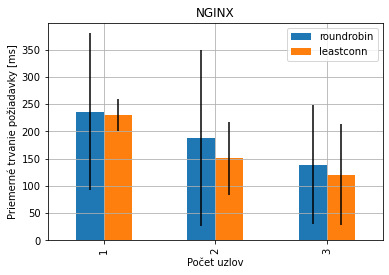

In [60]:
ab_connection_mean(a, 'NGINX')